In [1]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
from keras.layers import CuDNNLSTM as LSTM
from keras.layers import Dense, Bidirectional, Concatenate, Input
from keras.models import Model
import keras.backend as K
from keras.layers import Lambda, Dot
from keras.layers import RepeatVector 
from keras.layers import Embedding
from keras.optimizers import Adam

In [5]:
MAX_SENTENCES = 10000
MAX_VOCABULARY = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDINGS_DIM = 100
LATENT_ENCODER_DIM = 200
LATENT_DECODER_DIM = 150

In [6]:
spanish_input_sentences = []
spanish_output_sentences = []
english_sentences = []

count = 0
with open("./spa.txt", encoding="utf-8") as f:
    for line in f:
        if(count< MAX_SENTENCES):
            english, spanish = line.strip().split("\t");
            spanish_input = "<sos> " + spanish; 
            spanish_output = spanish + " <eos>"
            spanish_input_sentences.append(spanish_input);
            spanish_output_sentences.append(spanish_output);
            english_sentences.append(english);
            count += 1

In [8]:
encoder_tokenizer = Tokenizer(num_words = MAX_VOCABULARY)
decoder_tokenizer = Tokenizer(num_words = MAX_VOCABULARY, filters = '.')
#decoder_tokenizer = Tokenizer(num_words = MAX_VOCABULARY)
encoder_tokenizer.fit_on_texts(english_sentences)
decoder_tokenizer.fit_on_texts(spanish_input_sentences + spanish_output_sentences) #Dont remove special characers

In [9]:
encoder_sequences = encoder_tokenizer.texts_to_sequences(english_sentences)
decoder_sequences_input = decoder_tokenizer.texts_to_sequences(spanish_input_sentences)
decoder_sequences_target = decoder_tokenizer.texts_to_sequences(spanish_output_sentences)

In [10]:
MAX_ENCODER_SEQUENCE_LENGTH = max([len(sequence) for sequence in encoder_sequences])
MAX_DECODER_SEQUENCE_LENGTH = max([len(sequence) for sequence in decoder_sequences_input])
MAX_ENCODER_SEQUENCE_LENGTH = min(MAX_ENCODER_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH)
MAX_DECODER_SEQUENCE_LENGTH = min(MAX_DECODER_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH)
MAX_ENCODER_SEQUENCE_LENGTH, MAX_DECODER_SEQUENCE_LENGTH

(5, 9)

In [11]:
encoder_sequences_padded = pad_sequences(encoder_sequences, maxlen=MAX_ENCODER_SEQUENCE_LENGTH, padding='post')
decoder_sequences_input_padded = pad_sequences(decoder_sequences_input, maxlen=MAX_DECODER_SEQUENCE_LENGTH, padding='post')
decoder_sequences_target_padded = pad_sequences(decoder_sequences_target, maxlen=MAX_DECODER_SEQUENCE_LENGTH, padding='post')

In [12]:
#We need to add + 1 so as to take into account the index 0.
#In the output of the decoder we normally create a dense layer of size vocabulary_length taking for granted that
#index 0 is a valid index and part of our vocabulary. Keras tokenizer doesn't take the zero into account and we 
#need to correct for it. We add a 1 to our vocabulary_length so the final dense layer is size vocabulary_length + 1.
MAX_ENCODER_VOCABULARY = min(len(encoder_tokenizer.word_index), MAX_VOCABULARY) + 1
MAX_DECODER_VOCABULARY = min(len(decoder_tokenizer.word_index), MAX_VOCABULARY) + 1
MAX_ENCODER_VOCABULARY, MAX_DECODER_VOCABULARY

(2365, 5604)

In [13]:
encoder_word2idx = {}
encoder_idx2word = {}
decoder_word2idx = {}
decoder_idx2word = {}

for word, index in encoder_tokenizer.word_index.items():
    if index <= MAX_ENCODER_VOCABULARY:
        encoder_word2idx[word] = index;
        encoder_idx2word[index] = word;
        
for word, index in decoder_tokenizer.word_index.items():
    if index <= MAX_DECODER_VOCABULARY:
        decoder_word2idx[word] = index;
        decoder_idx2word[index] = word;

In [16]:
#One hot targets
one_hot_targets = np.zeros((len(decoder_sequences_target_padded), MAX_DECODER_SEQUENCE_LENGTH, MAX_DECODER_VOCABULARY))
for sequence_pos, sequence in enumerate(decoder_sequences_target_padded):
    for word_pos, word_idx in enumerate(sequence):
        one_hot_targets[sequence_pos, word_pos, word_idx] = 1.0

In [17]:
#100 vector dimension.
word2vec = {}
with open("../basic_language_models/large_files/glove.6B/glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        tokens = line.split();
        word = tokens[0];
        vector = np.array(tokens[1:])
        word2vec[word] = vector;

In [18]:
encoder_embeddings_weights = np.zeros((MAX_ENCODER_VOCABULARY, EMBEDDINGS_DIM));
for word, index in encoder_tokenizer.word_index.items():
    if index <= MAX_ENCODER_VOCABULARY:
        if word in word2vec:
            encoder_embeddings_weights[index] = word2vec[word]

In [19]:
def softmax_over_time(x):
    array_norm = K.exp(x - K.max(x, axis = 1, keepdims = True))
    return array_norm/K.sum(array_norm, axis = 1, keepdims = True)

In [20]:
encoder_embeddings = Embedding(input_dim = MAX_ENCODER_VOCABULARY, 
                        output_dim = EMBEDDINGS_DIM,
                        weights = [encoder_embeddings_weights],
                        input_length = MAX_ENCODER_SEQUENCE_LENGTH)

In [21]:
decoder_embeddings = Embedding(input_dim = MAX_DECODER_VOCABULARY,
                              output_dim = EMBEDDINGS_DIM)
                              #weights = [encoder_embeddings_weights])

In [22]:
encoder_input = Input([MAX_ENCODER_SEQUENCE_LENGTH])
encoder_input_embedded = encoder_embeddings(encoder_input)
lstm = LSTM(LATENT_ENCODER_DIM, return_sequences=True)
encoder_rnn = Bidirectional(lstm)(encoder_input_embedded)

def foo(module, x): pass <unknown> exec 1024
def foo(module, x): pass <unknown> exec 1024


In [23]:
encoder_rnn

<tf.Tensor 'bidirectional_1/concat_2:0' shape=(?, 5, 400) dtype=float32>

In [24]:
n_hidden1 = 10
repeat_layer = RepeatVector(MAX_ENCODER_SEQUENCE_LENGTH)
concatenate_layer = Concatenate()
dense1_layer = Dense(n_hidden1, activation='tanh')
dense2_layer = Dense(1, activation = softmax_over_time)
dot_layer = Dot(axes= 1)

def attention_layer(h, rnn_output):
    # rnn_output is the output of the bidirectional layer (?, Tx, 2*LATENT_ENCODER_DIM)
    # h is the last hidden state of the decoder lstm (?, LATENT_DECODER_DIM)

    h_T = repeat_layer(h) #(?, Tx, LATENT_DECODER_DIM)
    h_encoder_concat = concatenate_layer([h_T, rnn_output])  #(?, Tx, LATENT_DECODER_DIM), (?, Tx, 2*LATENT_ENCODER_DIM)
    #(?, T, LATENT_DECODER_DIM + 2*LATENT_ENCODER_DIM) ---> #(?, T, LATENT_DECODER_DIM + 2*LATENT_ENCODER_DIM)
    
    hidden1 = dense1_layer(h_encoder_concat)
    #print(hidden1)  #(?, Tx, n_hidden1)
    alphas = dense2_layer(hidden1)
    #print(alphas) #(?, Tx, 1)
    context = dot_layer([alphas, rnn_output])
    return alphas, context; #(?, 1, 2*LATENT_ENCODER_DIM)

In [25]:
#input_h = Input([LATENT_DECODER_DIM])
#attention_layer(input_h)
def permute_dimensions(x):
    #Stacking and permuting Must be inside a single function so they are passed together to the Lambda function
    #If done independently keras will complain that stack or permute_dimentions are not layers.
    x = K.stack(x)
    return K.permute_dimensions(x, (1, 0, 2))

In [26]:
MAX_DECODER_SEQUENCE_LENGTH

9

In [27]:
decoder_input = Input([MAX_DECODER_SEQUENCE_LENGTH], name= "decoder_input_")
decoder_input_embedded = decoder_embeddings(decoder_input)

lstm_decoder = LSTM(units = LATENT_DECODER_DIM, return_state=True);

dense_decoder = Dense(MAX_DECODER_VOCABULARY, activation = 'softmax');
concatenate_context_and_input = Concatenate(axis = 2)
h_init = Input([LATENT_DECODER_DIM], name = "h_init")
c_init = Input([LATENT_DECODER_DIM], name = "c_init")
h = h_init;
c = c_init;



In [28]:
outputs = []

for t in range(MAX_DECODER_SEQUENCE_LENGTH):
    selector = Lambda(lambda x: x[:, t: t + 1])    
    current_input = selector(decoder_input_embedded)  #(?, 1, EMBEDDIGS_DIM)
    __, context = attention_layer(h, encoder_rnn) #(?, 1, 2*LATENT_ENCODER_DIM)    
    #Teacher forcing

    context_concatenated = concatenate_context_and_input([context, current_input]) #(?, 1, EMBEDDINGS_DIM + 2*LATENT_ENCODER_DIM)
    o, h, c = lstm_decoder(context_concatenated, initial_state = [h, c])
    word_probs = dense_decoder(o) #(?, MAX_DECODER_VOCABULARY)
    outputs.append(word_probs)
    
    
#outputs is a list of Ty elements each of size batch_size, MAX_DECODER_VOCABULARY
 #(Ty, ?, MAX_DECODER_VOCABULARY)
outputs_layer = Lambda(permute_dimensions)(outputs)  #(?, Ty, MAX_DECODER_VOCABULARY)
    
#model = Model(inputs = [encoder_input, decoder_input, h_init, c_init], outputs = outputs)


In [29]:
model = Model(inputs = [encoder_input, decoder_input, h_init, c_init], outputs = outputs_layer)

In [30]:
m = len(encoder_sequences_padded)
h_init_ = np.zeros((m, LATENT_DECODER_DIM))
c_init_ = np.zeros((m, LATENT_DECODER_DIM))
model.compile(optimizer = Adam(0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [31]:

r = model.fit(x = [encoder_sequences_padded, decoder_sequences_input_padded, h_init_, c_init_], 
          y = one_hot_targets, 
          batch_size = 128, 
          epochs = 200, 
          validation_split = 0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/200
8000/8000 [==============================] - 47s 6ms/step - loss: 4.3010 - acc: 0.5710 - val_loss: 3.3599 - val_acc: 0.5258
Epoch 2/200
8000/8000 [==============================] - 46s 6ms/step - loss: 2.7631 - acc: 0.5807 - val_loss: 3.0868 - val_acc: 0.5258
Epoch 3/200
8000/8000 [==============================] - 47s 6ms/step - loss: 2.5181 - acc: 0.5961 - val_loss: 2.9332 - val_acc: 0.6048
Epoch 4/200
8000/8000 [==============================] - 44s 6ms/step - loss: 2.3827 - acc: 0.6807 - val_loss: 2.8390 - val_acc: 0.6354
Epoch 5/200
8000/8000 [==============================] - 44s 6ms/step - loss: 2.2946 - acc: 0.6917 - val_loss: 2.7922 - val_acc: 0.6367
Epoch 6/200
8000/8000 [==============================] - 44s 6ms/step - loss: 2.2328 - acc: 0.6932 - val_loss: 2.7418 - val_acc: 0.6369
Epoch 7/200
8000/8000 [==============================] - 43s 5ms/step - loss: 2.1827 - acc: 0.6981 - val_loss: 2.7113 - val_acc: 0.6501


8000/8000 [==============================] - 49s 6ms/step - loss: 0.6480 - acc: 0.8643 - val_loss: 1.9874 - val_acc: 0.7401
Epoch 61/200
8000/8000 [==============================] - 50s 6ms/step - loss: 0.6237 - acc: 0.8694 - val_loss: 1.9874 - val_acc: 0.7411
Epoch 62/200
8000/8000 [==============================] - 50s 6ms/step - loss: 0.6009 - acc: 0.8740 - val_loss: 1.9830 - val_acc: 0.7424
Epoch 63/200
8000/8000 [==============================] - 47s 6ms/step - loss: 0.5782 - acc: 0.8780 - val_loss: 1.9810 - val_acc: 0.7422
Epoch 64/200
8000/8000 [==============================] - 47s 6ms/step - loss: 0.5551 - acc: 0.8826 - val_loss: 1.9780 - val_acc: 0.7434
Epoch 65/200
8000/8000 [==============================] - 46s 6ms/step - loss: 0.5323 - acc: 0.8887 - val_loss: 1.9777 - val_acc: 0.7426
Epoch 66/200
8000/8000 [==============================] - 46s 6ms/step - loss: 0.5115 - acc: 0.8924 - val_loss: 1.9774 - val_acc: 0.7434
Epoch 67/200
8000/8000 [==============================

Epoch 120/200
8000/8000 [==============================] - 48s 6ms/step - loss: 0.0935 - acc: 0.9574 - val_loss: 2.0841 - val_acc: 0.7541
Epoch 121/200
8000/8000 [==============================] - 48s 6ms/step - loss: 0.0927 - acc: 0.9573 - val_loss: 2.0919 - val_acc: 0.7545
Epoch 122/200
8000/8000 [==============================] - 48s 6ms/step - loss: 0.0916 - acc: 0.9572 - val_loss: 2.0979 - val_acc: 0.7539
Epoch 123/200
8000/8000 [==============================] - 48s 6ms/step - loss: 0.0908 - acc: 0.9570 - val_loss: 2.0931 - val_acc: 0.7541
Epoch 124/200
8000/8000 [==============================] - 47s 6ms/step - loss: 0.0897 - acc: 0.9575 - val_loss: 2.0921 - val_acc: 0.7534
Epoch 125/200
8000/8000 [==============================] - 46s 6ms/step - loss: 0.0893 - acc: 0.9573 - val_loss: 2.0944 - val_acc: 0.7536
Epoch 126/200
8000/8000 [==============================] - 48s 6ms/step - loss: 0.0900 - acc: 0.9573 - val_loss: 2.0991 - val_acc: 0.7556
Epoch 127/200
8000/8000 [=========

8000/8000 [==============================] - 44s 5ms/step - loss: 0.0727 - acc: 0.9569 - val_loss: 2.2064 - val_acc: 0.7561
Epoch 180/200
8000/8000 [==============================] - 44s 6ms/step - loss: 0.0767 - acc: 0.9567 - val_loss: 2.2092 - val_acc: 0.7545
Epoch 181/200
8000/8000 [==============================] - 46s 6ms/step - loss: 0.0746 - acc: 0.9568 - val_loss: 2.2067 - val_acc: 0.7539
Epoch 182/200
8000/8000 [==============================] - 47s 6ms/step - loss: 0.0705 - acc: 0.9575 - val_loss: 2.2027 - val_acc: 0.7559
Epoch 183/200
8000/8000 [==============================] - 47s 6ms/step - loss: 0.0683 - acc: 0.9578 - val_loss: 2.2118 - val_acc: 0.7554
Epoch 184/200
8000/8000 [==============================] - 49s 6ms/step - loss: 0.0672 - acc: 0.9574 - val_loss: 2.2148 - val_acc: 0.7562
Epoch 185/200
8000/8000 [==============================] - 47s 6ms/step - loss: 0.0668 - acc: 0.9575 - val_loss: 2.2198 - val_acc: 0.7557
Epoch 186/200
8000/8000 [=======================

In [32]:
#model.save_weights("./19032019_weights_translator_last")

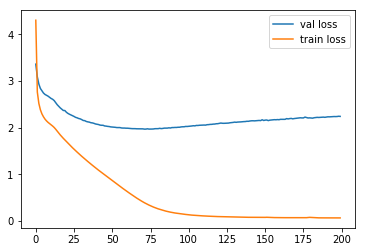

In [51]:
import matplotlib.pyplot as plt

plt.plot(r.history['val_loss'], label = "val loss")
plt.plot(r.history['loss'], label = "train loss")
plt.legend()
plt.show()

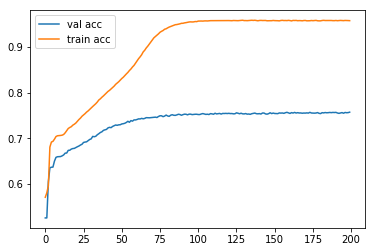

In [34]:
plt.plot(r.history['val_acc'], label = "val acc")
plt.plot(r.history['acc'], label = "train acc")
plt.legend()
plt.show()

In [35]:
#I create this model as a precomputation step. The subsequent prediction calculations will use the same bidirectional_model output
#given an ecoder_input. So we can save time.

#Input: encoder_input

bidirectional_model = Model(inputs = encoder_input, outputs = encoder_rnn)

#Input encoder_rnn

rnn_output_placeholder = Input([MAX_ENCODER_SEQUENCE_LENGTH, 2*LATENT_ENCODER_DIM])


#Will hold the last predicted word
decoder_input_pred = Input([1], name="decoder_input_pred")
decoder_input_pred_embedded = decoder_embeddings(decoder_input_pred)


alphas_pred,context_pred = attention_layer(h_init, rnn_output_placeholder)
context_pred_concatenated = concatenate_context_and_input([context_pred, decoder_input_pred_embedded])
o_curr, h_curr, c_curr = lstm_decoder(context_pred_concatenated, initial_state = [h_init, c_init])
probs_pred = dense_decoder(o_curr)
#translator_model = Model(inputs = [rnn_output_placeholder, h_init], outputs = [h_ss, a_ss, context_pred])
translator_model = Model(inputs = [rnn_output_placeholder, decoder_input_pred, h_init, c_init], outputs = [probs_pred, h_curr, c_curr, context_pred, alphas_pred])

In [45]:
def translate(sentence):
    
    encoder_sequence = encoder_tokenizer.texts_to_sequences([sentence])
    encoder_sequence_padded = pad_sequences(encoder_sequence, maxlen = MAX_ENCODER_SEQUENCE_LENGTH, padding = "post")
    
    decoder_input_pred_ = np.array([[decoder_word2idx['<sos>']]])
    h_init_ = np.zeros([1, LATENT_DECODER_DIM])
    c_init_ = np.zeros([1, LATENT_DECODER_DIM])
    output_sentence = []
    attention_matrix = np.zeros((MAX_DECODER_SEQUENCE_LENGTH, MAX_ENCODER_SEQUENCE_LENGTH))
    rnn_output_ = bidirectional_model.predict(encoder_sequence_padded);
    #print(np.sum(rnn_output_), rnn_output_.shape)
    #rnn_output_ = np.random.rand(1, 5, 300)
    #print(rnn_output_.shape, np.sum(rnn_output_))
    for t in range(MAX_DECODER_SEQUENCE_LENGTH):  
        #print(decoder_input_pred_)
        probs_pred_, h_init_, c_init_, context_prd_, alphas_pred_ = translator_model.predict([rnn_output_, decoder_input_pred_, h_init_, c_init_])
        attention_matrix[t] = alphas_pred_[0,:,0]
        #print("alphas:", alphas_pred_[0,:,0].shape)
        #print("output", np.sum(probs_pred_), np.sum(h_init_), np.sum(c_init_), np.sum(context_prd_))
        word_idx = np.argmax(probs_pred_[0][1:]) + 1;
        word = decoder_idx2word[word_idx];
        
        decoder_input_pred_[0, 0] = word_idx;
        output_sentence.append(word)
        
        if(word == '<eos>'):
            break;



    return attention_matrix, " ".join(output_sentence)

In [52]:
#index = 0
#english_sentence = english_sentences[index]
#attention_matrix, spanish_sentence = translate(english_sentence)
#spanish_sentence

In [47]:
import matplotlib.pyplot as plt

In [48]:
def plot_attention_matrix(attention_matrix, english_sentence, spanish_sentence):
    encoder_sequence = encoder_tokenizer.texts_to_sequences([english_sentence])
    labels = [''] + [encoder_idx2word[idx] for idx in encoder_sequence[0]] + ['']*(MAX_ENCODER_SEQUENCE_LENGTH - len(encoder_sequence))
    decoded_sequence = spanish_sentence.split()
    y_labels = [''] + decoded_sequence + ['']*(MAX_DECODER_SEQUENCE_LENGTH - len(decoded_sequence))
    
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    plt.imshow(attention_matrix, cmap = 'gray')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(y_labels)
    plt.show()

él salió a comer <eos>


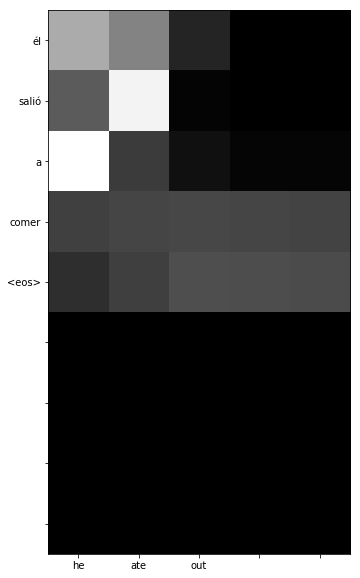

In [49]:
index = 1000
english_sentence = english_sentences[index]
encoder_sequence = encoder_tokenizer.texts_to_sequences([english_sentence])
attention_matrix, spanish_sentence = translate(english_sentence)
print(spanish_sentence)
plot_attention_matrix(attention_matrix, english_sentence, spanish_sentence)

In [50]:
while(True):
    res = input("Continue? y/n");
    if(res == 'y'):
        rand_index = np.random.randint(MAX_SENTENCES);
        english_sentence = english_sentences[rand_index];
        encoder_sequence = encoder_tokenizer.texts_to_sequences([english_sentence]);
        attention_matrix, spanish_sentence = translate(english_sentence);
        print("Original:", english_sentence)
        print("Translation:", spanish_sentence)
    else:
        break;
    

Continue? y/ny
Original: I'm a liar.
Translation: soy un mentiroso <eos>
Continue? y/ny
Original: I'm hungry.
Translation: me pica el bagre <eos>
Continue? y/ny
Original: That's not true.
Translation: no es verdad <eos>
Continue? y/ny
Original: That's a lot!
Translation: ¡es un montón! <eos>
Continue? y/ny
Original: He is old.
Translation: él es anciano <eos>
Continue? y/nn
